Author: Carlos Roberto de Melo

Date: 06/03/2020

Obj: Obter uma máscara baseada nos arcos gravitacioanis, de modo que possamos excluí-los da imagem original.

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from mpdaf.obj import Image, WCS
from mpdaf.obj import deg2sexa, sexa2deg

[INFO] 750 x 750 Image (/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Gravitational Arcs.fits)
[INFO] .data(750 x 750) (no unit), no noise
[INFO] center:(-38:10:33.4195,13:43:33.2207) size:(30.000",30.000") step:(0.040",0.040") rot:0.0 deg frame:FK5


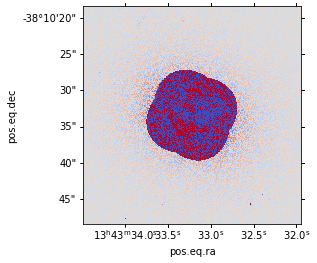

In [2]:
#Abrindo a imagem com os arcos
arcos = Image('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Gravitational Arcs.fits', ext=1)
arcos.info()
arcos.plot(use_wcs=True, cmap='coolwarm', zscale=True)

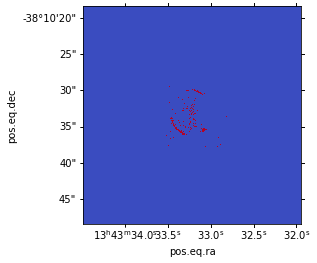

In [3]:
#Primeiro vamos selecionar apenas os pxs com valor acima de um certo threshold
arcos.data.data[arcos.data.data<0.5e-5] = 0
arcos.plot(vmin=0, vmax=0.5e-5, cmap='coolwarm', use_wcs=True)

Como se pode notar, ainda resta algum ruído no cenrtro dos arcos gravitacionais. Por esse motivo iremos criar uma máscara para estes pontos. Faremos uma máscara de formato circular, indo do centro dos arcos até bem próxima a borda.

**center**: centro da circunferência que será a máscara, formato (y,x).

**radius**: raio da circunferência que será a máscara.

**unit_center**: unidades para o centro em astropy units. Se None, é entendido unidades em pixel

**unit_radius**: unidades para o raio em astropy units. Se None, é entendido unidades em pixel

**inside**: se True, mascara os pontos internos da circunferência (atríbui valor 1), se False mascara os pontos externos a circunferência.

In [5]:
#Aqui estamos mascarando os pontos externos pois mais tarde iremos querer atribuir o valor zero apenas aos pontos
    #que fazendo parte dos arcos.
arcos.mask_region(center=(374,374), unit_center=None, radius=2.5, unit_radius=u.arcsec, inside=False)

#Agora salvamos os arcos + máscara interna
arcos.write('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Arcs with nuclear mask.fits')

In [6]:
#Agora abrimos os arcos + nuclear máscara, pois queremos multiplicar a máscara pela imagem dos arcos, de  modo a obtermos apenas os arcos
 #Mas para eliminarmos os resíduos externos, criaremos também outra máscara externa aos arcos
arcos = Image('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Arcs with nuclear mask.fits', ext=1) #Arcos
mask = Image('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Arcs with nuclear mask.fits', ext=2) #Máscara

#Obtenção dos arcos sem o ruído interno
final_arcs = arcos*mask

#Criando a máscara para eliminar o ruído externo
final_arcs.mask_region(center=(374,374), unit_center=None, radius=3.5, unit_radius=u.arcsec, inside=True)

final_arcs.write('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Arcs with all masks.fits')#Salvando


/home/carlos/anaconda3/lib/python3.7/site-packages/mpdaf/obj/image.py:3731: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(projection=self.wcs.wcs)


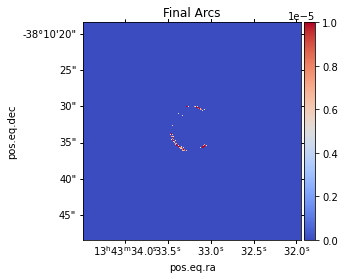

In [7]:
#Finalmente abrimos o imagem dos arcos com todas as máscaras necessárias, de modo a ficarmos apenas com os arcos

arcs = Image('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Arcs with all masks.fits', ext=1)
maskII = Image('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Arcs with all masks.fits', ext=2)

final_result = arcs*maskII #Arcos sem ruídos internos e externos

final_result.plot(vmin=0, vmax=0.5e-5, cmap='coolwarm', use_wcs=True)
final_result.plot(vmin=0, vmax=1e-5,cmap='coolwarm', use_wcs=True, colorbar='v', title='Final Arcs')
plt.savefig('/home/carlos/Desktop/ESO325 HST Data Reduction/Images/Final Arcs.png', fmt='png', dpi=1200)

final_result.write('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Final Arcs.fits')

In [8]:
#Uma vez obtidoso os arcos, vamos atribuir o valor zero a cada px correspondente

position = np.where(final_result.data.data>0) #Posição dos arcos
final_result[:] = 1 #Atribuí 1 a todos os pxs
final_result.data.data[position] = 0 #Em cada posição dos arcos, atribuí o valor zero

final_result.write('/home/carlos/Desktop/ESO325 HST Data Reduction/Data/Arcs Filter.fits') #Salvando o filtro baseado nos arcos